In [1]:
import numpy as np
from matplotlib import pyplot as plt

def show_as_image(binary_image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(binary_image, cmap='gray')
    plt.xticks([]); plt.yticks([])

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, utils
from torch.autograd import Variable

## Pixel CNN

Alternative to Pixel RNN from [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf). 

On-line resources:
 * See for an existing PyTorch implementation https://github.com/jzbontar/pixelcnn-pytorch/blob/master/main.py
 * http://sergeiturukin.com/2017/02/22/pixelcnn.html for a nice walk-through
 * http://tinyclouds.org/residency/
 * https://tensorflow.blog/2016/11/29/pixelcnn-1601-06759-summary/ (in korean ;) ) 

The core ideas are the following:

### Joint distribution of an image $\mathbf{x}$ modelled as an autoregressive process

Same model for PixelRNN and PixelCNN:

$$p(\mathbf{x}) = \prod_{i=1}^{n^2} p(x_i|x_{1}, \dots, x_{i-1})$$
 
![](http://sergeiturukin.com/assets/2017-02-22-183010_479x494_scrot.png)


## Causal or masked convolutions

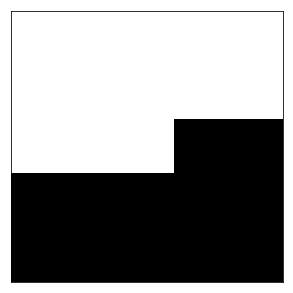

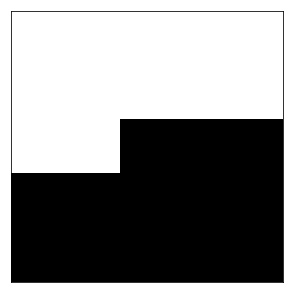

In [3]:
def causal_mask(width, height, starting_point):
    row_grid, col_grid = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    mask = np.logical_or(
        row_grid < starting_point[0],
        np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))
    return mask

def conv_mask(width, height, include_center=False):
    return 1.0 * causal_mask(width, height, starting_point=(width//2, height//2 + include_center - 1))

show_as_image(conv_mask(5, 5, include_center=True))

show_as_image(conv_mask(5, 5, include_center=False))

## Zero-ing all inputs weights after center point

In [4]:
out_channels, in_channels, width, height = 2, 2, 3, 3

conv_weights = 1 + np.arange(out_channels * in_channels * width * height).reshape((out_channels, in_channels, width, height))

masked_weights = conv_weights * conv_mask(width, height)

masked_weights


array([[[[  1.,   2.,   3.],
         [  4.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[ 10.,  11.,  12.],
         [ 13.,   0.,   0.],
         [  0.,   0.,   0.]]],


       [[[ 19.,  20.,  21.],
         [ 22.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[ 28.,  29.,  30.],
         [ 31.,   0.,   0.],
         [  0.,   0.,   0.]]]])

In [5]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        _, n_channels, width, height = self.weight.size()

        mask = conv_mask(width, height, include_center=mask_type=='B')
        self.register_buffer('mask', torch.from_numpy(mask).float())

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

### Fully convolutional network preserving spatial resolution

Input to output map      |  Output distribution
:-------------------------:|:-------------------------:
![](https://tensorflowkorea.files.wordpress.com/2016/11/pixel-cnn1.png)  |  ![](http://tinyclouds.org/residency/pixelcnn.png)

Quite a counter-intuitive model:

 * Convolutional layers bottom to top!
 * Last layer with `kernel_size=1` and outputs $ n_W \times n_H \times n_{pixels}$ logits, inferring $p(\mathbf{x})$ in one forward pass (during training)
 * Representation of dimension `n_channels` output by each layer anologous to RNN's internal state vector $\mathbf{h}$
 * Necessary to stack enough layers (and/or dillatations) to augment the "receptive field" so that output pixels can be influenced by the whole image
 

Below is a minimalistic implementation for 0/1 pixels without many of the bells and whistles of the original paper:

In [6]:
class PixelCNN(nn.Module):
    n_channels = 4
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels
    
    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )
        
    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

## Application on a simple generative model of LCD digits

From https://gist.github.com/benjaminwilson/b25a321f292f98d74269b83d4ed2b9a8#file-lcd-digits-dataset-nmf-ipynb

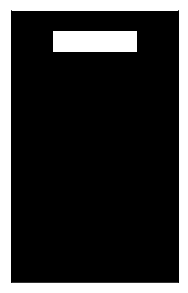

In [7]:
CELL_LENGTH = 4
IMAGE_WIDTH, IMAGE_HEIGHT = 2 * CELL_LENGTH + 5, CELL_LENGTH + 4

def vertical_stroke(rightness, downness):
    """
    Return a 2d numpy array representing an image with a single vertical stroke in it.
    `rightness` and `downness` are values from [0, 1] and define the position of the vertical stroke.
    """
    i = (downness * (CELL_LENGTH + 1)) + 2
    j = rightness * (CELL_LENGTH + 1) + 1
    x = np.zeros(shape=(IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.float64)
    x[i + np.arange(CELL_LENGTH), j] = 1.
    return x

def horizontal_stroke(downness):
    """
    Analogue to vertical_stroke, but it returns horizontal strokes.
    `downness` is here a value in [0, 1, 2].
    """
    i = (downness * (CELL_LENGTH + 1)) + 1
    x = np.zeros(shape=(IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.float64)
    x[i, 2 + np.arange(CELL_LENGTH)] = 1.
    return x

show_as_image(horizontal_stroke(0))

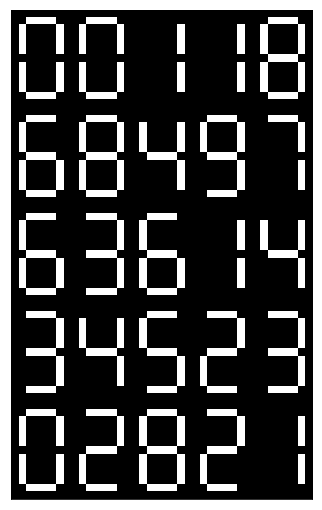

In [8]:
BASE_STROKES = np.asarray(
    [horizontal_stroke(k) for k in range(3)] + [vertical_stroke(k, l) for k in range(2) for l in range(2)])

DIGITS_STROKES = np.array([[0, 2, 3, 4, 5, 6], [5, 6], [0, 1, 2, 4, 5], [0, 1, 2, 5, 6], [1, 3, 5, 6], [0, 1, 2, 3, 6], [0, 1, 2, 3, 4, 6], [0, 5, 6], np.arange(7), [0, 1, 2, 3, 5, 6]])

def random_digits(strokes=BASE_STROKES, digit_as_strokes=DIGITS_STROKES, fixed_label=None):
    label = fixed_label if fixed_label is not None else np.random.choice(len(digit_as_strokes))
    combined_strokes = strokes[digit_as_strokes[label], :, :].sum(axis=0)
    return combined_strokes, label

def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])


show_as_image(batch_images_to_one(np.stack([random_digits()[0] for _ in range(25)])), figsize=(9, 9))

In [9]:
from torch.utils.data import Dataset, DataLoader


class LcdDigits(Dataset):

    def __init__(self, n_examples):
        digits, labels = zip(*[random_digits() for _ in range(n_examples)])
        self.digits = np.asarray(digits, dtype=np.float64)
        self.labels = np.asarray(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        digit_with_channel = self.digits[idx][np.newaxis, :, :]
        
        return torch.from_numpy(digit_with_channel).float(), torch.from_numpy(np.array([self.labels[idx]]))

next(b for b in DataLoader(LcdDigits(128), batch_size=3))

[
 (0 ,0 ,.,.) = 
    0   0   0   0   0   0   0   0
    0   0   1   1   1   1   0   0
    0   1   0   0   0   0   1   0
    0   1   0   0   0   0   1   0
    0   1   0   0   0   0   1   0
    0   1   0   0   0   0   1   0
    0   0   1   1   1   1   0   0
    0   1   0   0   0   0   1   0
    0   1   0   0   0   0   1   0
    0   1   0   0   0   0   1   0
    0   1   0   0   0   0   1   0
    0   0   1   1   1   1   0   0
    0   0   0   0   0   0   0   0
 
 (1 ,0 ,.,.) = 
    0   0   0   0   0   0   0   0
    0   0   1   1   1   1   0   0
    0   1   0   0   0   0   0   0
    0   1   0   0   0   0   0   0
    0   1   0   0   0   0   0   0
    0   1   0   0   0   0   0   0
    0   0   1   1   1   1   0   0
    0   0   0   0   0   0   1   0
    0   0   0   0   0   0   1   0
    0   0   0   0   0   0   1   0
    0   0   0   0   0   0   1   0
    0   0   1   1   1   1   0   0
    0   0   0   0   0   0   0   0
 
 (2 ,0 ,.,.) = 
    0   0   0   0   0   0   0   0
    0   0   1   1   1   1   

## Training

In [10]:
import torch.nn.functional as F

N_EPOCHS = 25
BATCH_SIZE = 128
LR = 0.005

cnn = PixelCNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

train_dataset = LcdDigits(BATCH_SIZE * 50)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(N_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = Variable(images)
        optimizer.zero_grad()
        loss = F.cross_entropy(input=cnn(images), target=torch.squeeze(images).long())
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, N_EPOCHS, loss.data[0]))

Epoch [1/25], Loss: 0.5733
Epoch [2/25], Loss: 0.2885
Epoch [3/25], Loss: 0.0838
Epoch [4/25], Loss: 0.0447
Epoch [5/25], Loss: 0.0351
Epoch [6/25], Loss: 0.0332
Epoch [7/25], Loss: 0.0306
Epoch [8/25], Loss: 0.0301
Epoch [9/25], Loss: 0.0282
Epoch [10/25], Loss: 0.0280
Epoch [11/25], Loss: 0.0271
Epoch [12/25], Loss: 0.0270
Epoch [13/25], Loss: 0.0266
Epoch [14/25], Loss: 0.0268
Epoch [15/25], Loss: 0.0260
Epoch [16/25], Loss: 0.0257
Epoch [17/25], Loss: 0.0257
Epoch [18/25], Loss: 0.0256
Epoch [19/25], Loss: 0.0255
Epoch [20/25], Loss: 0.0253
Epoch [21/25], Loss: 0.0254
Epoch [22/25], Loss: 0.0253
Epoch [23/25], Loss: 0.0251
Epoch [24/25], Loss: 0.0246
Epoch [25/25], Loss: 0.0246


## Sequentially generating new samples 

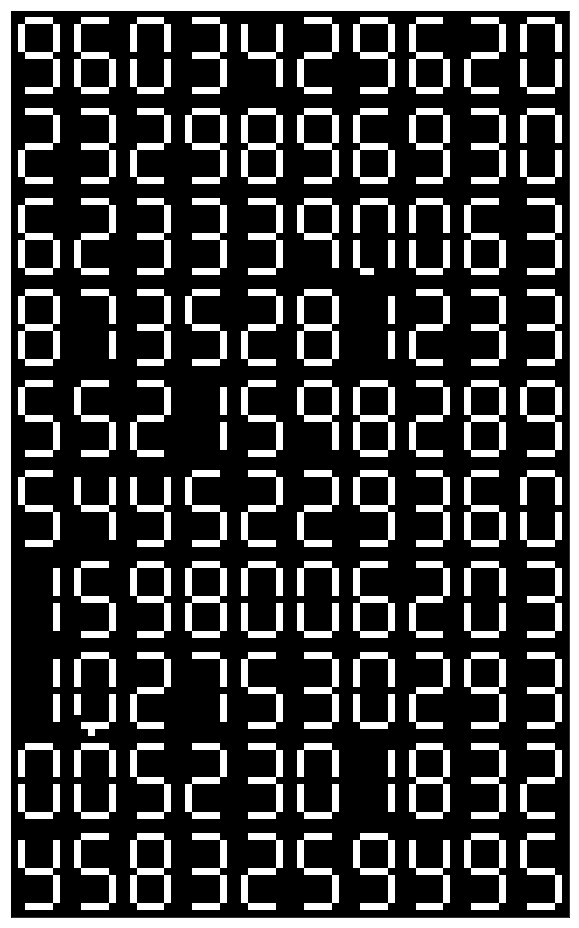

In [11]:
def generate_samples(n_samples, starting_point=(0, 0), starting_image=None):

    samples = torch.from_numpy(
        starting_image if starting_image is not None else np.zeros((n_samples * n_samples, 1, IMAGE_WIDTH, IMAGE_HEIGHT))).float()

    cnn.train(False)

    for i in range(IMAGE_WIDTH):
        for j in range(IMAGE_HEIGHT):
            if i < starting_point[0] or (i == starting_point[0] and j < starting_point[1]):
                continue
            out = cnn(Variable(samples, volatile=True))
            probs = F.softmax(out[:, :, i, j]).data
            samples[:, :, i, j] = torch.multinomial(probs, 1).float()
    return samples.numpy()

show_as_image(batch_images_to_one(generate_samples(n_samples=10)), figsize=(10, 20))

## Or completing existing cropped image

 * $0, 8, 9$ and $2, 3, 7$ undistinguishable early one
 * Very small amount of noise (jitter) in samples
 * The last horizontal bar is hard to predict as it depends on the 1st horizontal bar
 * ($4, 9$) sometimes lead to incomplete or erroneous images because of the long term dependency between the upper and lower horizontal bars (could be improved by increasing the receptive field with more layers or "à trous" convolutions)

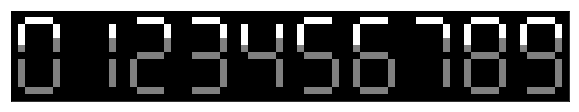

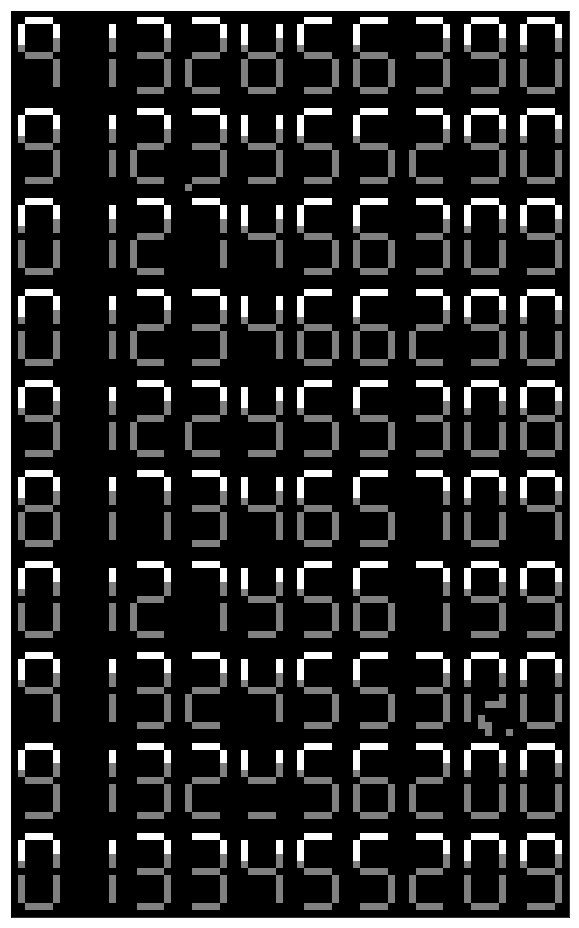

In [12]:
n_images = 10
starting_point = (4, 3)

mask = causal_mask(IMAGE_WIDTH, IMAGE_HEIGHT, starting_point)

starting_images = digits_list = [random_digits(fixed_label=d)[0] for d in range(10)]
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(n_images, starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(10, 10))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(10, 20))